In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("advertising.csv")
print(df.shape)
df.head()

(200, 5)


,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
Unnamed: 0    200 non-null int64
TV            200 non-null float64
radio         200 non-null float64
newspaper     200 non-null float64
sales         200 non-null float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [4]:
df.describe()

,Unnamed: 0,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


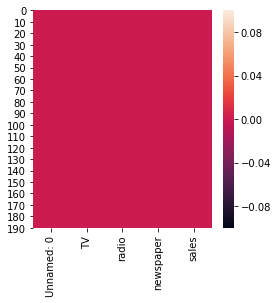

In [5]:
plt.figure(figsize=(4,4))
sns.heatmap(df.isnull())
plt.show()

there is no null value

In [6]:
df=df.drop("Unnamed: 0",axis=1)

to check correlation with sales

sales        1.000000
TV           0.782224
radio        0.576223
newspaper    0.228299
Name: sales, dtype: float64


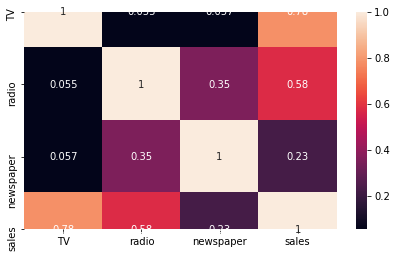

In [7]:
print(df.corr()["sales"].sort_values(ascending=False))
plt.figure(figsize=(7,4))
sns.heatmap(df.corr(),annot=True)
plt.show()

to check presence of outliers

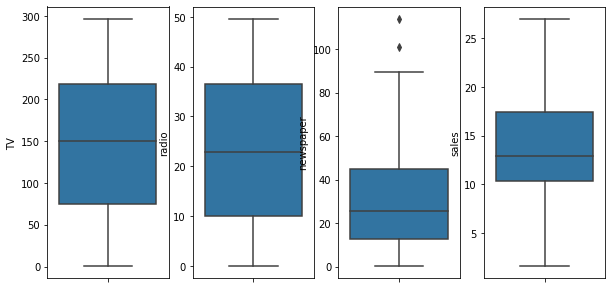

In [8]:
c=df.columns
plt.figure(figsize=(10,5))
for i in range(len(c)):
    plt.subplot(1,4,i+1)
    sns.boxplot(df[c[i]],orient="v")

to remove outliers

In [9]:
from scipy.stats import zscore
z=np.abs(zscore(df))
df1=df[(z<3).all(axis=1)]

In [10]:
print(df.shape)
print(df1.shape)

(200, 4)
(198, 4)


to find presence of skewness

TV          -0.082332
radio        0.114842
newspaper    0.650112
sales        0.407130
dtype: float64


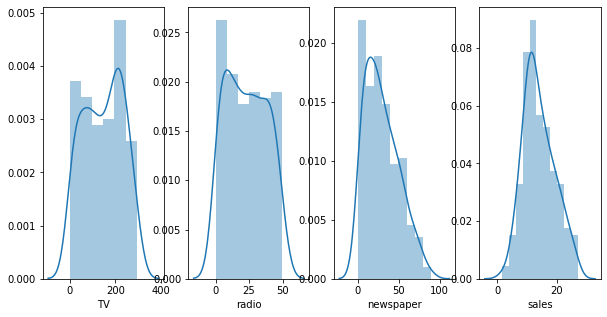

In [11]:
print(df1.skew())
plt.figure(figsize=(10,5))
for i in range(len(c)):
    plt.subplot(1,4,i+1)
    sns.distplot(df1[c[i]])

In [13]:
df1["newspaper"]=np.cbrt(df1["newspaper"])
df1.skew()

TV          -0.082332
radio        0.114842
newspaper   -0.341008
sales        0.407130
dtype: float64

In [14]:
x=df1.iloc[:,0:-1]
y=df1.iloc[:,-1]
print(x.shape)
print(y.shape)

(198, 3)
(198,)


To find best random state

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split

In [16]:
macc=0
rand=0
for i in range(200):
    xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=.20,random_state=i)
    lr=LinearRegression()
    lr.fit(xtrain,ytrain)
    pred=lr.predict(xtest)
    acc=r2_score(ytest,pred)
    if acc>macc:
        macc=acc
        rand=i
print("random state : ",rand,"acc : ",macc)
print("mse",mean_squared_error(ytest,pred))
print("moe",mean_absolute_error(ytest,pred))

random state :  24 acc :  0.9473901983341664
mse 4.889835271740637
moe 1.4736110896711054


In [17]:
from sklearn.svm import SVR
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=.20,random_state=151)
svr=SVR()
svr.fit(xtrain,ytrain)
pred=svr.predict(xtest)
print("mse",mean_squared_error(ytest,pred))
print("moe",mean_absolute_error(ytest,pred))
print("r2score",r2_score(ytest,pred))

mse 20.155846754896714
moe 3.578923045355036
r2score -0.02704428282641702


to find best model

In [18]:
from sklearn.model_selection import cross_val_score
mod=[lr,svr]
for i in mod:
    cvs=cross_val_score(i,x,y,cv=4)
    print("cross_val_score : ",i,cvs.mean())

cross_val_score :  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 0.8885900019980308
cross_val_score :  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) -0.03472860703357267


Linear Regression is seam to be a better model

Hyper Parameter Tuneing

In [36]:
from sklearn.model_selection import GridSearchCV
para={"copy_X":["True","False"], "fit_intercept":["True","False"]}

In [37]:
GScv=GridSearchCV(lr,para,cv=4)
GScv.fit(x,y)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=None,
             param_grid={'copy_X': ['True', 'False'],
                         'fit_intercept': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [38]:
GScv.best_params_

{'copy_X': 'True', 'fit_intercept': 'True'}

In [42]:
gvpred=GScv.predict(x)
r2_score(y,gvpred)

0.8953928934531011

due to hyper parameter tuneing the accuracy svore is improved by 1%

In [43]:
import joblib
joblib.dump(lr,"sales.obj")

['sales.obj']

In [44]:
v=joblib.load("sales.obj")

In [45]:
l=np.array([44.5,39.3,45.1])
l=l.reshape(1,-1)

In [46]:
df

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


In [47]:
v.predict(l)

array([6.3186041])